In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

7

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sun Apr 14 21:01:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 13%   51C    P2              57W / 250W |    494MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

    

Using device: cuda


In [5]:
from stable_baselines3.common.env_util import make_atari_env
env_id="SpaceInvadersNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
print(info[0])
env = make_atari_env(env_id, n_envs=1)
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)
# print(env.action_space.n)
# print(env.observation_space.shape[0])

(100000, 4, 84, 84) (100000,) (100000,) (100000,) (100000,) (100000, 4, 84, 84)
{'lives': 3, 'episode_frame_number': 34, 'frame_number': 34, 'TimeLimit.truncated': False}


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(1, 4, 84, 84)


In [6]:
obs = env.reset()
print(obs.shape)

(1, 4, 84, 84)


In [7]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:

policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)



train_dataset = CustomDataset(observations, actions)

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)


# Training loop
num_epochs = 30
batch_size = 32

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()
log_interval = len(observations)//10
num_test=5
test_score = 0
now_log=0
now_pos=0
graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    now_log=0
    now_pos=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        obs_batch=obs_batch.to(device)
        act_batch=act_batch.to(device)
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()




        #scheduler

        graph.append(loss.detach().item())
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./gif/"+image_path, frames)


            
            # print(total_reward/num_test)
            test_score = total_reward/num_test
                
            eval_rewards.append(total_reward/num_test)

            policy_network.train()      
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item(), "test_score":test_score})
env.close()

    


Epoch [1/30]:  10%|▉         | 311/3125 [00:03<00:13, 210.82it/s, loss=0.28] /mnt/nfs/work/c98181/miniconda3/envs/atari/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
Epoch [1/30]:  11%|█▏        | 355/3125 [00:07<01:50, 25.04it/s, loss=0.501] 

[5.8]


Epoch [1/30]:  21%|██▏       | 667/3125 [00:10<00:59, 41.44it/s, loss=0.212]  

[3.8]


Epoch [1/30]:  31%|███       | 975/3125 [00:14<00:59, 35.88it/s, loss=0.11]   

[4.8]


Epoch [1/30]:  41%|████      | 1277/3125 [00:18<00:44, 41.31it/s, loss=0.0603]  

[6.4]


Epoch [1/30]:  51%|█████     | 1587/3125 [00:23<00:58, 26.18it/s, loss=0.0377]  

[7.4]


Epoch [1/30]:  61%|██████    | 1908/3125 [00:26<00:23, 52.06it/s, loss=0.022]  

[2.6]


Epoch [1/30]:  71%|███████   | 2226/3125 [00:29<00:17, 52.56it/s, loss=0.0633]  

[2.6]


Epoch [1/30]:  81%|████████  | 2522/3125 [00:32<00:15, 39.09it/s, loss=0.152]   

[4.]


Epoch [1/30]:  91%|█████████ | 2840/3125 [00:35<00:05, 47.88it/s, loss=0.0213]  

[2.]


Epoch [1/30]: 100%|██████████| 3125/3125 [00:40<00:00, 76.98it/s, loss=0.123]   


[6.8]


Epoch [2/30]:  11%|█▏        | 359/3125 [00:03<01:06, 41.81it/s, loss=0.289]   

[3.2]


Epoch [2/30]:  21%|██▏       | 670/3125 [00:09<01:37, 25.23it/s, loss=0.163]   

[10.6]


Epoch [2/30]:  31%|███▏      | 984/3125 [00:11<00:34, 61.42it/s, loss=0.0136]   

[3.]


Epoch [2/30]:  41%|████▏     | 1295/3125 [00:14<00:35, 51.83it/s, loss=0.0093]   

[3.2]


Epoch [2/30]:  51%|█████     | 1592/3125 [00:18<00:34, 44.64it/s, loss=0.00321] 

[4.2]


Epoch [2/30]:  61%|██████▏   | 1919/3125 [00:22<00:38, 31.40it/s, loss=0.0783]  

[5.]


Epoch [2/30]:  71%|███████   | 2211/3125 [00:25<00:19, 46.80it/s, loss=0.0612]   

[5.2]


Epoch [2/30]:  81%|████████▏ | 2540/3125 [00:29<00:15, 37.64it/s, loss=0.116]    

[4.6]


Epoch [2/30]:  91%|█████████▏| 2859/3125 [00:33<00:06, 38.78it/s, loss=0.0777]   

[6.4]


Epoch [2/30]: 100%|██████████| 3125/3125 [00:36<00:00, 84.50it/s, loss=0.0934]  


[3.6]


Epoch [3/30]:  11%|█         | 341/3125 [00:03<00:59, 46.59it/s, loss=0.00181]  

[4.]


Epoch [3/30]:  21%|██        | 660/3125 [00:07<00:58, 42.07it/s, loss=0.000888] 

[8.2]


Epoch [3/30]:  31%|███       | 968/3125 [00:10<00:43, 49.43it/s, loss=0.0961]  

[3.6]


Epoch [3/30]:  41%|████      | 1281/3125 [00:14<00:48, 37.90it/s, loss=0.0469]   

[6.4]


Epoch [3/30]:  51%|█████     | 1601/3125 [00:17<00:29, 52.19it/s, loss=0.0246]   

[3.2]


Epoch [3/30]:  61%|██████    | 1900/3125 [00:20<00:32, 37.79it/s, loss=0.000827] 

[3.6]


Epoch [3/30]:  71%|███████   | 2221/3125 [00:23<00:16, 53.59it/s, loss=0.000354] 

[3.]


Epoch [3/30]:  81%|████████  | 2536/3125 [00:27<00:16, 35.10it/s, loss=0.037]    

[6.8]


Epoch [3/30]:  91%|█████████ | 2842/3125 [00:32<00:11, 25.26it/s, loss=0.0325]   

[7.4]


Epoch [3/30]: 100%|██████████| 3125/3125 [00:36<00:00, 86.19it/s, loss=0.00173]  


[6.6]


Epoch [4/30]:  11%|█▏        | 359/3125 [00:07<02:26, 18.93it/s, loss=0.000197] 

[18.2]


Epoch [4/30]:  21%|██        | 652/3125 [00:11<01:18, 31.57it/s, loss=0.000211] 

[13.4]


Epoch [4/30]:  31%|███       | 965/3125 [00:18<02:05, 17.26it/s, loss=5.8e-5]   

[18.]


Epoch [4/30]:  41%|████      | 1279/3125 [00:23<00:58, 31.62it/s, loss=8.9e-5]   

[12.4]


Epoch [4/30]:  51%|█████     | 1593/3125 [00:30<01:25, 17.97it/s, loss=4.52e-5]  

[19.]


Epoch [4/30]:  61%|██████    | 1903/3125 [00:33<00:32, 37.83it/s, loss=0.356]    

[5.2]


Epoch [4/30]:  71%|███████   | 2212/3125 [00:37<00:21, 43.39it/s, loss=0.019]   

[4.6]


Epoch [4/30]:  81%|████████  | 2537/3125 [00:41<00:17, 33.40it/s, loss=0.0022]   

[4.8]


Epoch [4/30]:  91%|█████████ | 2834/3125 [00:44<00:07, 38.88it/s, loss=0.00395]  

[3.]


Epoch [4/30]: 100%|██████████| 3125/3125 [00:48<00:00, 64.02it/s, loss=0.000597] 


[7.]


Epoch [5/30]:  11%|█         | 340/3125 [00:05<01:44, 26.62it/s, loss=2.35e-5]  

[13.6]


Epoch [5/30]:  21%|██        | 657/3125 [00:11<02:14, 18.30it/s, loss=0.000183] 

[15.8]


Epoch [5/30]:  31%|███       | 969/3125 [00:15<00:53, 40.20it/s, loss=0.000105] 

[6.6]


Epoch [5/30]:  41%|████      | 1282/3125 [00:21<01:24, 21.78it/s, loss=5.45e-5]  

[14.6]


Epoch [5/30]:  51%|█████     | 1597/3125 [00:27<01:16, 19.93it/s, loss=4.92e-5]  

[18.4]


Epoch [5/30]:  61%|██████    | 1901/3125 [00:32<00:46, 26.42it/s, loss=7.47e-5]  

[18.6]


Epoch [5/30]:  71%|███████▏  | 2228/3125 [00:37<00:29, 29.98it/s, loss=3.5e-5]   

[13.2]


Epoch [5/30]:  81%|████████  | 2537/3125 [00:41<00:18, 31.16it/s, loss=7.64e-5]  

[12.2]


Epoch [5/30]:  91%|█████████ | 2850/3125 [00:49<00:16, 16.33it/s, loss=6.78e-5]  

[20.]


Epoch [5/30]: 100%|██████████| 3125/3125 [00:53<00:00, 58.58it/s, loss=0.328]   


[5.]


Epoch [6/30]:  11%|█         | 338/3125 [00:03<00:54, 51.33it/s, loss=0.0224]  

[5.6]


Epoch [6/30]:  21%|██        | 656/3125 [00:06<00:52, 47.23it/s, loss=0.00109]  

[6.4]


Epoch [6/30]:  31%|███       | 970/3125 [00:11<01:19, 27.03it/s, loss=0.000652] 

[11.2]


Epoch [6/30]:  41%|████      | 1280/3125 [00:15<00:47, 38.70it/s, loss=0.00026]  

[12.]


Epoch [6/30]:  51%|█████     | 1587/3125 [00:21<01:13, 20.92it/s, loss=0.0112]   

[13.6]


Epoch [6/30]:  61%|██████    | 1913/3125 [00:24<00:25, 46.78it/s, loss=0.041]    

[3.4]


Epoch [6/30]:  71%|███████▏  | 2227/3125 [00:30<00:41, 21.76it/s, loss=0.0354]   

[9.8]


Epoch [6/30]:  81%|████████▏ | 2544/3125 [00:34<00:16, 36.26it/s, loss=0.0944]   

[6.6]


Epoch [6/30]:  92%|█████████▏| 2860/3125 [00:39<00:09, 28.69it/s, loss=0.0568]   

[12.8]


Epoch [6/30]: 100%|██████████| 3125/3125 [00:43<00:00, 72.30it/s, loss=6.44e-5]  


[13.]


Epoch [7/30]:  12%|█▏        | 360/3125 [00:05<01:37, 28.30it/s, loss=0.0644]   

[10.6]


Epoch [7/30]:  21%|██▏       | 669/3125 [00:07<00:36, 68.03it/s, loss=0.0278]   

[2.8]


Epoch [7/30]:  31%|███       | 964/3125 [00:11<01:07, 31.98it/s, loss=0.00116]  

[9.4]


Epoch [7/30]:  41%|████      | 1280/3125 [00:19<01:51, 16.49it/s, loss=0.000557] 

[15.4]


Epoch [7/30]:  51%|█████     | 1591/3125 [00:24<01:09, 22.23it/s, loss=0.0001]   

[11.6]


Epoch [7/30]:  61%|██████    | 1903/3125 [00:30<00:48, 24.99it/s, loss=6.06e-5]  

[16.6]


Epoch [7/30]:  71%|███████   | 2217/3125 [00:34<00:25, 36.14it/s, loss=5.35e-5]  

[12.8]


Epoch [7/30]:  81%|████████  | 2527/3125 [00:41<00:31, 18.81it/s, loss=2.51e-5]  

[20.8]


Epoch [7/30]:  91%|█████████ | 2842/3125 [00:45<00:08, 32.52it/s, loss=2.17e-5]  

[11.4]


Epoch [7/30]: 100%|██████████| 3125/3125 [00:50<00:00, 61.45it/s, loss=4.75e-5]  


[19.4]


Epoch [8/30]:  11%|█         | 350/3125 [00:05<02:00, 23.04it/s, loss=4.14e-5]  

[12.]


Epoch [8/30]:  21%|██        | 653/3125 [00:11<01:53, 21.81it/s, loss=4.7e-5]   

[14.6]


Epoch [8/30]:  31%|███       | 970/3125 [00:17<01:44, 20.57it/s, loss=5.12e-5]  

[11.6]


Epoch [8/30]:  41%|████      | 1284/3125 [00:24<01:45, 17.45it/s, loss=2.31e-5]  

[16.6]


Epoch [8/30]:  51%|█████     | 1594/3125 [00:27<00:28, 53.63it/s, loss=3.22e-5]  

[5.8]


Epoch [8/30]:  61%|██████▏   | 1916/3125 [00:34<01:03, 18.92it/s, loss=4.17e-5]  

[20.4]


Epoch [8/30]:  71%|███████▏  | 2228/3125 [00:39<00:33, 26.82it/s, loss=4.77e-5]  

[12.]


Epoch [8/30]:  81%|████████  | 2535/3125 [00:43<00:16, 36.43it/s, loss=0.0752]  

[5.6]


Epoch [8/30]:  91%|█████████ | 2845/3125 [00:47<00:07, 36.86it/s, loss=0.0338]   

[8.4]


Epoch [8/30]: 100%|██████████| 3125/3125 [00:52<00:00, 59.76it/s, loss=0.00048]  


[12.]


Epoch [9/30]:  11%|█         | 344/3125 [00:03<00:51, 53.67it/s, loss=0.000591] 

[3.8]


Epoch [9/30]:  21%|██        | 652/3125 [00:07<01:13, 33.64it/s, loss=5.78e-5]  

[7.2]


Epoch [9/30]:  31%|███       | 961/3125 [00:12<01:32, 23.43it/s, loss=0.000122] 

[12.]


Epoch [9/30]:  41%|████      | 1277/3125 [00:21<02:06, 14.56it/s, loss=0.000146] 

[20.]


Epoch [9/30]:  51%|█████     | 1595/3125 [00:30<01:59, 12.84it/s, loss=8.94e-5]  

[26.8]


Epoch [9/30]:  61%|██████    | 1901/3125 [00:37<01:02, 19.45it/s, loss=6.67e-5]  

[16.6]


Epoch [9/30]:  71%|███████   | 2214/3125 [00:40<00:25, 36.08it/s, loss=6.51e-5]  

[11.6]


Epoch [9/30]:  81%|████████  | 2531/3125 [00:45<00:18, 32.79it/s, loss=9.9e-5]   

[11.6]


Epoch [9/30]:  91%|█████████ | 2848/3125 [00:48<00:05, 48.59it/s, loss=9.29e-5]  

[5.8]


Epoch [9/30]: 100%|██████████| 3125/3125 [00:56<00:00, 55.56it/s, loss=6.02e-5]  


[20.]


Epoch [10/30]:  11%|█         | 345/3125 [00:03<00:58, 47.49it/s, loss=1.18]     

[6.2]


Epoch [10/30]:  21%|██        | 660/3125 [00:06<00:56, 43.71it/s, loss=0.0473]  

[5.2]


Epoch [10/30]:  31%|███       | 976/3125 [00:10<00:44, 48.02it/s, loss=0.00173]  

[4.2]


Epoch [10/30]:  41%|████▏     | 1291/3125 [00:14<00:50, 36.39it/s, loss=0.0442]   

[7.]


Epoch [10/30]:  51%|█████     | 1601/3125 [00:17<00:40, 37.37it/s, loss=0.000118] 

[9.]


Epoch [10/30]:  61%|██████▏   | 1918/3125 [00:23<00:51, 23.51it/s, loss=0.00153]  

[8.8]


Epoch [10/30]:  71%|███████   | 2225/3125 [00:27<00:23, 38.22it/s, loss=0.0828]   

[5.6]


Epoch [10/30]:  81%|████████  | 2530/3125 [00:30<00:15, 37.96it/s, loss=0.414]    

[5.8]


Epoch [10/30]:  91%|█████████▏| 2852/3125 [00:34<00:05, 46.75it/s, loss=0.000114] 

[8.4]


Epoch [10/30]: 100%|██████████| 3125/3125 [00:40<00:00, 78.05it/s, loss=0.0367]   


[13.6]


Epoch [11/30]:  11%|█         | 335/3125 [00:04<01:43, 27.07it/s, loss=0.000118] 

[8.4]


Epoch [11/30]:  21%|██        | 658/3125 [00:10<01:47, 22.97it/s, loss=6.78e-5]  

[13.2]


Epoch [11/30]:  31%|███       | 968/3125 [00:16<01:48, 19.80it/s, loss=0.000104] 

[20.8]


Epoch [11/30]:  41%|████      | 1288/3125 [00:24<01:57, 15.57it/s, loss=4.19e-5]  

[19.4]


Epoch [11/30]:  51%|█████▏    | 1603/3125 [00:30<01:13, 20.70it/s, loss=5.21e-5]  

[20.]


Epoch [11/30]:  61%|██████    | 1913/3125 [00:36<00:56, 21.35it/s, loss=6.8e-5]   

[19.2]


Epoch [11/30]:  71%|███████▏  | 2228/3125 [00:41<00:31, 28.75it/s, loss=0.533]   

[7.4]


Epoch [11/30]:  81%|████████▏ | 2541/3125 [00:46<00:22, 25.79it/s, loss=0.0464]   

[11.2]


Epoch [11/30]:  91%|█████████ | 2850/3125 [00:50<00:08, 31.58it/s, loss=0.000378] 

[10.4]


Epoch [11/30]: 100%|██████████| 3125/3125 [00:58<00:00, 53.75it/s, loss=0.000792] 


[19.6]


Epoch [12/30]:  11%|█▏        | 355/3125 [00:06<02:18, 20.06it/s, loss=6.96e-5]  

[11.6]


Epoch [12/30]:  21%|██        | 650/3125 [00:14<02:50, 14.53it/s, loss=0.000176] 

[19.4]


Epoch [12/30]:  31%|███▏      | 980/3125 [00:19<01:21, 26.46it/s, loss=6.72e-5]  

[13.4]


Epoch [12/30]:  41%|████      | 1289/3125 [00:24<01:09, 26.59it/s, loss=7.3e-5]   

[10.]


Epoch [12/30]:  51%|█████     | 1587/3125 [00:30<01:09, 22.12it/s, loss=8.03e-5]  

[20.8]


Epoch [12/30]:  61%|██████    | 1907/3125 [00:37<01:09, 17.50it/s, loss=7.1e-5]   

[17.8]


Epoch [12/30]:  71%|███████   | 2222/3125 [00:41<00:29, 30.16it/s, loss=2.8e-5]   

[11.6]


Epoch [12/30]:  81%|████████  | 2527/3125 [00:45<00:18, 31.72it/s, loss=6.59e-5]  

[12.]


Epoch [12/30]:  91%|█████████▏| 2856/3125 [00:50<00:08, 31.11it/s, loss=0.000104] 

[14.2]


Epoch [12/30]: 100%|██████████| 3125/3125 [00:56<00:00, 55.53it/s, loss=3.43e-5]  


[18.4]


Epoch [13/30]:  11%|█▏        | 355/3125 [00:03<01:07, 41.07it/s, loss=0.0157]  

[9.]


Epoch [13/30]:  21%|██        | 664/3125 [00:07<01:10, 34.67it/s, loss=0.00176]  

[7.8]


Epoch [13/30]:  31%|███▏      | 981/3125 [00:12<01:04, 33.13it/s, loss=0.0001]   

[6.6]


Epoch [13/30]:  41%|████      | 1277/3125 [00:15<00:46, 39.34it/s, loss=0.000552] 

[7.]


Epoch [13/30]:  51%|█████     | 1591/3125 [00:20<00:52, 28.95it/s, loss=0.000172] 

[12.8]


Epoch [13/30]:  61%|██████▏   | 1920/3125 [00:23<00:26, 45.90it/s, loss=0.0051]   

[7.8]


Epoch [13/30]:  71%|███████▏  | 2230/3125 [00:26<00:17, 50.18it/s, loss=0.0517]   

[6.]


Epoch [13/30]:  81%|████████▏ | 2540/3125 [00:31<00:19, 30.47it/s, loss=0.219]    

[7.4]


Epoch [13/30]:  91%|█████████ | 2837/3125 [00:35<00:09, 30.10it/s, loss=0.0112]   

[12.6]


Epoch [13/30]: 100%|██████████| 3125/3125 [00:40<00:00, 78.09it/s, loss=0.0015]   


[9.2]


Epoch [14/30]:  11%|█         | 344/3125 [00:07<02:35, 17.86it/s, loss=5.31e-5]  

[16.2]


Epoch [14/30]:  21%|██        | 650/3125 [00:13<02:11, 18.86it/s, loss=8.16e-5]  

[18.2]


Epoch [14/30]:  31%|███▏      | 983/3125 [00:20<01:51, 19.24it/s, loss=3.66e-5]  

[21.4]


Epoch [14/30]:  41%|████      | 1278/3125 [00:27<01:37, 18.87it/s, loss=6.57e-5]  

[18.8]


Epoch [14/30]:  51%|█████     | 1591/3125 [00:34<01:35, 16.07it/s, loss=7.76e-5]  

[18.2]


Epoch [14/30]:  61%|██████    | 1907/3125 [00:39<00:46, 26.41it/s, loss=2.65e-5]  

[12.6]


Epoch [14/30]:  71%|███████   | 2223/3125 [00:43<00:24, 36.28it/s, loss=4.91e-5]  

[12.]


Epoch [14/30]:  81%|████████  | 2525/3125 [00:48<00:19, 31.39it/s, loss=0.000162] 

[13.6]


Epoch [14/30]:  91%|█████████ | 2838/3125 [00:52<00:09, 31.52it/s, loss=3.85e-5]  

[10.]


Epoch [14/30]: 100%|██████████| 3125/3125 [00:57<00:00, 54.31it/s, loss=5.91e-5]  


[13.6]


Epoch [15/30]:  11%|█         | 333/3125 [00:07<03:40, 12.69it/s, loss=6.95e-5]  

[18.2]


Epoch [15/30]:  21%|██        | 662/3125 [00:10<00:53, 46.41it/s, loss=0.467]    

[3.2]


Epoch [15/30]:  31%|███       | 972/3125 [00:14<01:11, 30.05it/s, loss=0.0753]  

[7.]


Epoch [15/30]:  41%|████▏     | 1290/3125 [00:17<00:34, 53.89it/s, loss=0.032]    

[6.4]


Epoch [15/30]:  51%|█████▏    | 1606/3125 [00:20<00:28, 52.50it/s, loss=0.000298] 

[7.6]


Epoch [15/30]:  61%|██████▏   | 1915/3125 [00:25<00:44, 27.35it/s, loss=0.000307] 

[12.]


Epoch [15/30]:  71%|███████   | 2226/3125 [00:30<00:25, 35.23it/s, loss=0.0007]   

[7.2]


Epoch [15/30]:  81%|████████  | 2537/3125 [00:36<00:28, 20.58it/s, loss=0.000257] 

[20.4]


Epoch [15/30]:  91%|█████████ | 2842/3125 [00:43<00:18, 15.42it/s, loss=8.81e-5]  

[18.2]


Epoch [15/30]: 100%|██████████| 3125/3125 [00:49<00:00, 62.51it/s, loss=5.38e-5]  


[15.]


Epoch [16/30]:  11%|█▏        | 355/3125 [00:07<02:28, 18.71it/s, loss=7.91e-5]  

[18.]


Epoch [16/30]:  21%|██▏       | 668/3125 [00:11<01:25, 28.85it/s, loss=4.69e-5]  

[13.6]


Epoch [16/30]:  31%|███       | 960/3125 [00:19<02:59, 12.05it/s, loss=8.87e-5]  

[19.4]


Epoch [16/30]:  41%|████▏     | 1291/3125 [00:23<00:59, 30.99it/s, loss=9.52e-5]  

[12.2]


Epoch [16/30]:  51%|█████▏    | 1603/3125 [00:29<01:03, 24.02it/s, loss=4.16e-5]  

[11.6]


Epoch [16/30]:  61%|██████    | 1913/3125 [00:37<01:19, 15.20it/s, loss=3.58e-5]  

[26.6]


Epoch [16/30]:  71%|███████   | 2221/3125 [00:42<00:36, 25.06it/s, loss=8.96e-5]  

[20.]


Epoch [16/30]:  81%|████████  | 2529/3125 [00:46<00:14, 41.96it/s, loss=0.667]    

[6.8]


Epoch [16/30]:  91%|█████████ | 2839/3125 [00:49<00:06, 41.48it/s, loss=0.00675]  

[4.2]


Epoch [16/30]: 100%|██████████| 3125/3125 [00:55<00:00, 56.67it/s, loss=0.00423]  


[10.8]


Epoch [17/30]:  11%|█         | 336/3125 [00:04<01:26, 32.33it/s, loss=0.0138]   

[9.4]


Epoch [17/30]:  21%|██        | 654/3125 [00:07<00:59, 41.32it/s, loss=0.000666] 

[4.2]


Epoch [17/30]:  31%|███       | 975/3125 [00:12<01:09, 30.79it/s, loss=0.000209] 

[10.4]


Epoch [17/30]:  41%|████      | 1281/3125 [00:15<00:42, 43.26it/s, loss=0.000796] 

[7.8]


Epoch [17/30]:  51%|█████     | 1590/3125 [00:19<00:40, 38.24it/s, loss=0.911]   

[6.]


Epoch [17/30]:  61%|██████    | 1905/3125 [00:25<00:55, 21.82it/s, loss=0.00159]  

[11.4]


Epoch [17/30]:  71%|███████   | 2220/3125 [00:33<00:56, 16.14it/s, loss=0.000898] 

[20.2]


Epoch [17/30]:  81%|████████▏ | 2541/3125 [00:39<00:25, 23.24it/s, loss=0.000108] 

[12.]


Epoch [17/30]:  91%|█████████▏| 2856/3125 [00:46<00:16, 16.29it/s, loss=9.88e-5]  

[18.4]


Epoch [17/30]: 100%|██████████| 3125/3125 [00:51<00:00, 60.80it/s, loss=3.11e-5]  


[14.]


Epoch [18/30]:  11%|█         | 338/3125 [00:06<02:16, 20.46it/s, loss=0.000206] 

[19.]


Epoch [18/30]:  21%|██▏       | 670/3125 [00:13<02:04, 19.78it/s, loss=8.72e-6]  

[19.2]


Epoch [18/30]:  31%|███       | 968/3125 [00:17<01:12, 29.87it/s, loss=7.82e-5]  

[12.8]


Epoch [18/30]:  41%|████      | 1279/3125 [00:24<01:37, 18.94it/s, loss=2.79e-5]  

[14.6]


Epoch [18/30]:  51%|█████     | 1588/3125 [00:29<01:08, 22.53it/s, loss=5.89e-5]  

[17.]


Epoch [18/30]:  61%|██████▏   | 1918/3125 [00:34<00:39, 30.50it/s, loss=7.48e-5]  

[13.4]


Epoch [18/30]:  71%|███████   | 2213/3125 [00:40<00:42, 21.46it/s, loss=2.21e-5]  

[18.4]


Epoch [18/30]:  81%|████████  | 2523/3125 [00:46<00:34, 17.61it/s, loss=5.45e-5]  

[20.4]


Epoch [18/30]:  91%|█████████ | 2850/3125 [00:53<00:18, 15.22it/s, loss=2.42e-5]  

[19.]


Epoch [18/30]: 100%|██████████| 3125/3125 [00:56<00:00, 55.02it/s, loss=0.0722]  


[4.4]


Epoch [19/30]:  11%|█         | 349/3125 [00:03<00:51, 54.18it/s, loss=0.0182]   

[4.4]


Epoch [19/30]:  21%|██        | 656/3125 [00:07<01:13, 33.64it/s, loss=0.000274] 

[8.6]


Epoch [19/30]:  31%|███       | 962/3125 [00:11<01:11, 30.39it/s, loss=0.000237] 

[13.2]


Epoch [19/30]:  41%|████▏     | 1294/3125 [00:17<01:12, 25.10it/s, loss=0.000166] 

[18.8]


Epoch [19/30]:  51%|█████▏    | 1602/3125 [00:22<01:03, 24.15it/s, loss=4.53e-5]  

[20.4]


Epoch [19/30]:  61%|██████    | 1897/3125 [00:27<00:47, 25.63it/s, loss=9.65e-5]  

[13.4]


Epoch [19/30]:  71%|███████   | 2221/3125 [00:35<00:53, 16.79it/s, loss=1.27e-5]  

[17.8]


Epoch [19/30]:  81%|████████  | 2538/3125 [00:38<00:10, 54.69it/s, loss=0.000133] 

[5.8]


Epoch [19/30]:  91%|█████████ | 2851/3125 [00:44<00:12, 22.61it/s, loss=4.69e-5]  

[18.2]


Epoch [19/30]: 100%|██████████| 3125/3125 [00:48<00:00, 64.82it/s, loss=7.6e-5]   


[13.]


Epoch [20/30]:  11%|█         | 336/3125 [00:07<03:43, 12.51it/s, loss=5.88e-5]  

[19.4]


Epoch [20/30]:  21%|██        | 657/3125 [00:12<01:28, 27.82it/s, loss=0.000118] 

[13.]


Epoch [20/30]:  31%|███       | 960/3125 [00:16<01:11, 30.19it/s, loss=0.182]   

[7.2]


Epoch [20/30]:  41%|████▏     | 1294/3125 [00:21<00:59, 30.76it/s, loss=0.00211] 

[7.]


Epoch [20/30]:  51%|█████▏    | 1606/3125 [00:24<00:32, 46.91it/s, loss=0.000164] 

[5.]


Epoch [20/30]:  61%|██████▏   | 1921/3125 [00:29<00:43, 27.62it/s, loss=0.000467] 

[12.]


Epoch [20/30]:  71%|███████   | 2216/3125 [00:38<01:04, 14.02it/s, loss=0.000144] 

[26.4]


Epoch [20/30]:  81%|████████  | 2527/3125 [00:43<00:21, 27.71it/s, loss=0.000157] 

[12.6]


Epoch [20/30]:  91%|█████████ | 2844/3125 [00:48<00:12, 22.02it/s, loss=7.07e-5]  

[14.2]


Epoch [20/30]: 100%|██████████| 3125/3125 [00:54<00:00, 57.40it/s, loss=0.000156] 


[11.6]


Epoch [21/30]:  11%|█▏        | 355/3125 [00:06<02:23, 19.32it/s, loss=8.37e-5]  

[20.]


Epoch [21/30]:  21%|██        | 655/3125 [00:11<01:29, 27.56it/s, loss=6.9e-5]   

[10.]


Epoch [21/30]:  31%|███▏      | 977/3125 [00:17<01:34, 22.62it/s, loss=0.000137] 

[19.4]


Epoch [21/30]:  41%|████      | 1286/3125 [00:24<01:55, 15.90it/s, loss=5.41e-5]  

[21.4]


Epoch [21/30]:  51%|█████▏    | 1603/3125 [00:29<01:02, 24.30it/s, loss=0.00911]  

[11.6]


Epoch [21/30]:  61%|██████    | 1907/3125 [00:32<00:20, 60.58it/s, loss=0.2]     

[2.]


Epoch [21/30]:  71%|███████▏  | 2227/3125 [00:36<00:26, 33.39it/s, loss=0.000313] 

[10.2]


Epoch [21/30]:  81%|████████  | 2533/3125 [00:40<00:15, 37.21it/s, loss=0.00943]  

[9.]


Epoch [21/30]:  91%|█████████ | 2837/3125 [00:45<00:09, 29.59it/s, loss=0.000405] 

[11.6]


Epoch [21/30]: 100%|██████████| 3125/3125 [00:48<00:00, 64.11it/s, loss=0.0146]   


[10.4]


Epoch [22/30]:  11%|█▏        | 357/3125 [00:03<01:02, 44.17it/s, loss=0.141]    

[6.8]


Epoch [22/30]:  21%|██▏       | 666/3125 [00:10<02:01, 20.16it/s, loss=5.4e-5]   

[13.6]


Epoch [22/30]:  31%|███       | 957/3125 [00:15<02:17, 15.73it/s, loss=0.000518] 

[15.6]


Epoch [22/30]:  41%|████      | 1281/3125 [00:20<01:03, 29.24it/s, loss=0.000195] 

[8.]


Epoch [22/30]:  51%|█████     | 1598/3125 [00:26<01:02, 24.41it/s, loss=0.000106] 

[17.4]


Epoch [22/30]:  61%|██████    | 1911/3125 [00:31<00:46, 26.31it/s, loss=9.16e-5]  

[12.8]


Epoch [22/30]:  71%|███████   | 2226/3125 [00:35<00:29, 30.23it/s, loss=4e-5]     

[13.8]


Epoch [22/30]:  81%|████████  | 2530/3125 [00:44<00:44, 13.38it/s, loss=5.57e-5]  

[25.8]


Epoch [22/30]:  91%|█████████ | 2842/3125 [00:51<00:14, 19.36it/s, loss=7.08e-5]  

[14.6]


Epoch [22/30]: 100%|██████████| 3125/3125 [00:58<00:00, 53.69it/s, loss=4.7e-5]   


[17.8]


Epoch [23/30]:  11%|█▏        | 353/3125 [00:04<01:19, 34.72it/s, loss=1.64e-5]  

[12.8]


Epoch [23/30]:  21%|██        | 664/3125 [00:09<01:42, 24.06it/s, loss=0.0148]   

[12.8]


Epoch [23/30]:  31%|███▏      | 981/3125 [00:13<00:51, 41.55it/s, loss=0.00301]  

[5.6]


Epoch [23/30]:  41%|████      | 1272/3125 [00:17<00:50, 36.71it/s, loss=0.087]    

[7.4]


Epoch [23/30]:  51%|█████     | 1589/3125 [00:25<01:56, 13.21it/s, loss=0.00102]  

[25.]


Epoch [23/30]:  61%|██████    | 1900/3125 [00:30<00:41, 29.72it/s, loss=0.000199] 

[13.8]


Epoch [23/30]:  71%|███████   | 2219/3125 [00:40<01:08, 13.24it/s, loss=8.19e-5]  

[34.]


Epoch [23/30]:  81%|████████  | 2537/3125 [00:44<00:21, 26.84it/s, loss=0.000206] 

[10.]


Epoch [23/30]:  91%|█████████ | 2847/3125 [00:50<00:13, 20.59it/s, loss=7.89e-5]  

[20.4]


Epoch [23/30]: 100%|██████████| 3125/3125 [00:58<00:00, 52.98it/s, loss=6.82e-5]  


[20.4]


Epoch [24/30]:  11%|█         | 349/3125 [00:07<03:00, 15.42it/s, loss=0.000449] 

[18.6]


Epoch [24/30]:  21%|██        | 649/3125 [00:13<01:41, 24.37it/s, loss=3.75e-5]  

[11.2]


Epoch [24/30]:  31%|███       | 971/3125 [00:16<00:38, 55.99it/s, loss=0.458]    

[3.4]


Epoch [24/30]:  41%|████      | 1287/3125 [00:19<00:37, 48.74it/s, loss=0.0248]   

[4.8]


Epoch [24/30]:  51%|█████     | 1599/3125 [00:23<00:42, 36.18it/s, loss=0.00199]  

[10.]


Epoch [24/30]:  61%|██████    | 1910/3125 [00:26<00:23, 51.10it/s, loss=0.000146] 

[5.6]


Epoch [24/30]:  71%|███████   | 2222/3125 [00:31<00:35, 25.70it/s, loss=9.2e-5]   

[12.]


Epoch [24/30]:  81%|████████  | 2521/3125 [00:37<00:28, 21.39it/s, loss=8.71e-5]  

[13.2]


Epoch [24/30]:  91%|█████████▏| 2857/3125 [00:42<00:11, 23.54it/s, loss=4.77e-5]  

[11.6]


Epoch [24/30]: 100%|██████████| 3125/3125 [00:50<00:00, 61.53it/s, loss=3.83e-5]  


[19.6]


Epoch [25/30]:  11%|█         | 344/3125 [00:07<02:35, 17.90it/s, loss=0.000187] 

[18.]


Epoch [25/30]:  21%|██        | 661/3125 [00:11<01:08, 35.74it/s, loss=4.53e-5]  

[12.]


Epoch [25/30]:  31%|███▏      | 979/3125 [00:16<01:24, 25.26it/s, loss=8.7e-5]   

[20.4]


Epoch [25/30]:  41%|████▏     | 1290/3125 [00:22<01:26, 21.34it/s, loss=0.000191] 

[17.8]


Epoch [25/30]:  51%|█████     | 1592/3125 [00:27<00:44, 34.12it/s, loss=9.19e-5]  

[11.6]


Epoch [25/30]:  61%|██████    | 1910/3125 [00:30<00:25, 48.32it/s, loss=0.0461]   

[4.2]


Epoch [25/30]:  71%|███████   | 2219/3125 [00:34<00:32, 28.28it/s, loss=0.00428]  

[10.2]


Epoch [25/30]:  81%|████████  | 2525/3125 [00:38<00:18, 32.55it/s, loss=0.0113]   

[10.6]


Epoch [25/30]:  91%|█████████ | 2849/3125 [00:42<00:07, 38.01it/s, loss=0.000289] 

[8.]


Epoch [25/30]: 100%|██████████| 3125/3125 [00:48<00:00, 64.90it/s, loss=0.000268] 


[14.6]


Epoch [26/30]:  11%|█         | 338/3125 [00:04<01:30, 30.85it/s, loss=9.41e-5]  

[13.8]


Epoch [26/30]:  21%|██        | 650/3125 [00:10<01:51, 22.29it/s, loss=4.3e-5]   

[18.2]


Epoch [26/30]:  31%|███       | 961/3125 [00:14<01:05, 32.99it/s, loss=2.97e-5]  

[11.4]


Epoch [26/30]:  41%|████      | 1271/3125 [00:20<01:49, 16.87it/s, loss=6.54e-5]  

[18.2]


Epoch [26/30]:  51%|█████     | 1597/3125 [00:26<01:11, 21.43it/s, loss=0.000118] 

[18.8]


Epoch [26/30]:  61%|██████    | 1909/3125 [00:30<00:34, 34.91it/s, loss=3.19e-5]  

[12.]


Epoch [26/30]:  71%|███████   | 2219/3125 [00:34<00:24, 36.49it/s, loss=8.33e-5]  

[12.]


Epoch [26/30]:  81%|████████  | 2526/3125 [00:38<00:19, 30.75it/s, loss=8.52e-5]  

[14.2]


Epoch [26/30]:  91%|█████████ | 2834/3125 [00:45<00:14, 19.42it/s, loss=7.49e-5]  

[16.6]


Epoch [26/30]: 100%|██████████| 3125/3125 [00:47<00:00, 65.16it/s, loss=0.249]   


[4.4]


Epoch [27/30]:  11%|█         | 349/3125 [00:04<01:35, 29.08it/s, loss=0.0022]   

[9.4]


Epoch [27/30]:  21%|██        | 644/3125 [00:12<03:36, 11.46it/s, loss=0.000659] 

[16.]


Epoch [27/30]:  31%|███▏      | 977/3125 [00:15<00:42, 50.20it/s, loss=0.00024]  

[6.4]


Epoch [27/30]:  41%|████      | 1288/3125 [00:19<00:54, 33.53it/s, loss=8.6e-5]   

[12.4]


Epoch [27/30]:  51%|█████▏    | 1604/3125 [00:22<00:26, 57.91it/s, loss=5.05e-5]  

[5.8]


Epoch [27/30]:  61%|██████    | 1899/3125 [00:28<01:19, 15.42it/s, loss=0.000143] 

[18.6]


Epoch [27/30]:  71%|███████   | 2209/3125 [00:35<01:00, 15.18it/s, loss=9.67e-5]  

[14.6]


Epoch [27/30]:  81%|████████  | 2524/3125 [00:42<00:34, 17.61it/s, loss=5.48e-5]  

[18.6]


Epoch [27/30]:  91%|█████████ | 2842/3125 [00:47<00:13, 21.62it/s, loss=9.8e-5]   

[13.4]


Epoch [27/30]: 100%|██████████| 3125/3125 [00:52<00:00, 59.64it/s, loss=4.56e-5]  


[11.2]


Epoch [28/30]:  11%|█▏        | 357/3125 [00:04<01:23, 33.28it/s, loss=6.72e-5]  

[13.]


Epoch [28/30]:  21%|██▏       | 669/3125 [00:09<01:21, 30.26it/s, loss=0.0309]   

[9.6]


Epoch [28/30]:  31%|███▏      | 979/3125 [00:13<01:04, 33.06it/s, loss=0.0047]   

[12.]


Epoch [28/30]:  41%|████      | 1283/3125 [00:18<01:16, 23.96it/s, loss=0.000447] 

[13.6]


Epoch [28/30]:  51%|█████     | 1591/3125 [00:24<01:09, 22.16it/s, loss=7.92e-5]  

[11.8]


Epoch [28/30]:  61%|██████▏   | 1915/3125 [00:29<00:56, 21.35it/s, loss=0.000578] 

[12.6]


Epoch [28/30]:  71%|███████▏  | 2228/3125 [00:36<00:42, 21.01it/s, loss=0.000261] 

[17.8]


Epoch [28/30]:  81%|████████▏ | 2542/3125 [00:38<00:09, 64.02it/s, loss=7.51e-5]  

[3.]


Epoch [28/30]:  91%|█████████▏| 2853/3125 [00:46<00:15, 17.56it/s, loss=0.000102] 

[19.6]


Epoch [28/30]: 100%|██████████| 3125/3125 [00:51<00:00, 60.23it/s, loss=0.000113] 


[17.4]


Epoch [29/30]:  11%|█         | 334/3125 [00:05<02:38, 17.56it/s, loss=3.95e-5]  

[11.2]


Epoch [29/30]:  21%|██        | 649/3125 [00:10<01:26, 28.70it/s, loss=0.000201] 

[14.2]


Epoch [29/30]:  31%|███       | 963/3125 [00:18<02:16, 15.81it/s, loss=0.000167] 

[25.8]


Epoch [29/30]:  41%|████      | 1280/3125 [00:23<01:12, 25.44it/s, loss=9.06e-5]  

[13.4]


Epoch [29/30]:  51%|█████     | 1590/3125 [00:28<00:58, 26.17it/s, loss=9.78e-5]  

[11.6]


Epoch [29/30]:  61%|██████    | 1905/3125 [00:35<01:02, 19.62it/s, loss=0.000138] 

[18.2]


Epoch [29/30]:  71%|███████   | 2222/3125 [00:37<00:16, 54.65it/s, loss=0.148]   

[0.8]


Epoch [29/30]:  81%|████████  | 2537/3125 [00:41<00:13, 43.44it/s, loss=0.175]    

[5.8]


Epoch [29/30]:  91%|█████████ | 2850/3125 [00:47<00:11, 23.11it/s, loss=0.000501] 

[11.6]


Epoch [29/30]: 100%|██████████| 3125/3125 [00:53<00:00, 58.64it/s, loss=0.000115] 


[18.6]


Epoch [30/30]:  11%|█         | 348/3125 [00:06<02:10, 21.21it/s, loss=0.000181] 

[15.]


Epoch [30/30]:  21%|██        | 662/3125 [00:14<02:50, 14.44it/s, loss=3.37e-5]  

[20.4]


Epoch [30/30]:  31%|███       | 973/3125 [00:22<02:10, 16.46it/s, loss=7.5e-5]   

[18.]


Epoch [30/30]:  41%|████      | 1286/3125 [00:25<00:50, 36.17it/s, loss=0.0389]   

[12.2]


Epoch [30/30]:  51%|█████     | 1598/3125 [00:29<00:36, 41.76it/s, loss=0.0467]   

[4.6]


Epoch [30/30]:  61%|██████    | 1911/3125 [00:33<00:32, 37.29it/s, loss=0.0135]   

[7.8]


Epoch [30/30]:  71%|███████   | 2221/3125 [00:36<00:20, 43.11it/s, loss=0.023]    

[10.2]


Epoch [30/30]:  81%|████████  | 2536/3125 [00:39<00:10, 57.21it/s, loss=0.000291] 

[5.8]


Epoch [30/30]:  91%|█████████ | 2848/3125 [00:43<00:07, 37.60it/s, loss=0.00074]  

[6.2]


Epoch [30/30]: 100%|██████████| 3125/3125 [00:47<00:00, 65.71it/s, loss=0.000514] 

[9.2]


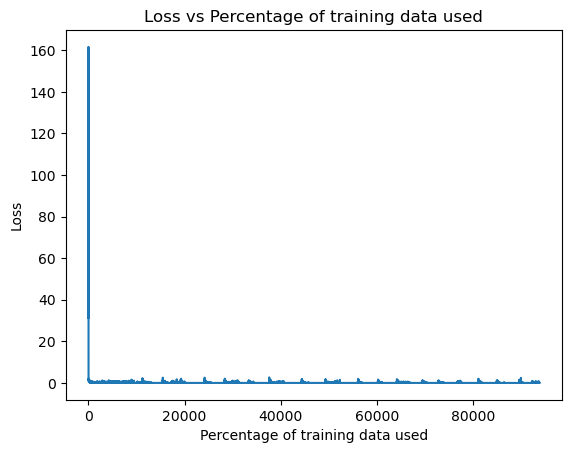

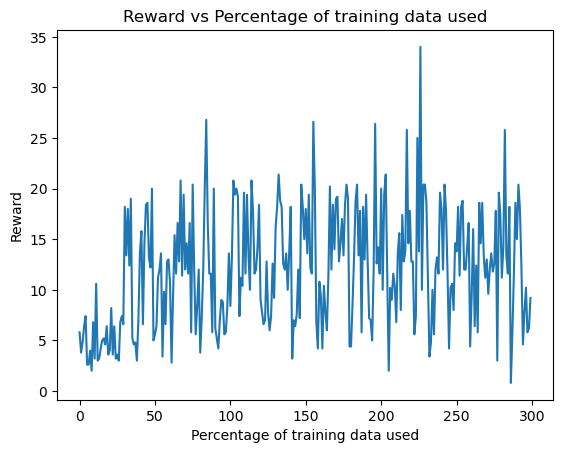

: 

In [9]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Loss")
plt.title("Loss vs Percentage of training data used")

plt.savefig("./loss.png")
plt.show()
# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Percentage of training data used")
plt.ylabel("Reward")
plt.title("Reward vs Percentage of training data used")
plt.savefig("./reward.png")
plt.show()


